In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [47]:

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [48]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [49]:

# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [50]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [53]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [55]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5143

Testing
Number of Labels: 1311


In [56]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [57]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [58]:
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [60]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.4725 - loss: 1.1062 - val_accuracy: 0.6789 - val_loss: 0.8272 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.7968 - loss: 0.5308 - val_accuracy: 0.7574 - val_loss: 0.5703 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.8586 - loss: 0.3728 - val_accuracy: 0.8444 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.8983 - loss: 0.2845 - val_accuracy: 0.8841 - val_loss: 0.3250 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9198 - loss: 0.2175 - val_accuracy: 0.8993 - val_loss: 0.2765 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.9406 - loss: 0.1736 - val_accuracy: 0.9268 - val_loss: 0.2071 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.94

In [61]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9852 - loss: 0.1303
Test accuracy: 98.5507%


In [62]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       300
           1       0.98      0.97      0.97       306
           2       0.98      1.00      0.99       405
           3       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.99      1311
weighted avg       0.99      0.99      0.99      1311



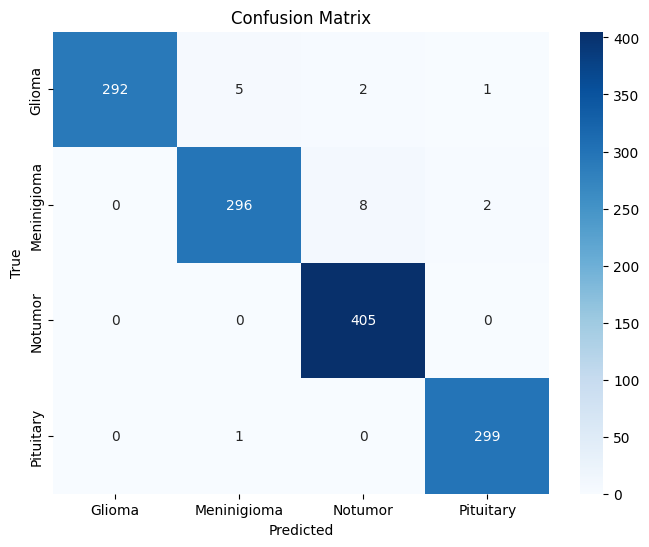

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [64]:
model.save('SSL_90-50.h5')

In [65]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime

# Define paths
MODEL_PATH = "SSL_90-50.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/unlabelled"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
CONFIDENCE_THRESHOLD = 0.98
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Saving {img_file} to {output_path}")
        img.save(output_path)

print("✅ Pseudo-labeling completed. Check the output folder for labeled images.")


  0%|          | 0/569 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


  0%|          | 1/569 [00:00<06:22,  1.49it/s]

Tr-pi_1149.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1149.jpg to BT100/Training/pituitary/20250328_215836_Tr-pi_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1169.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1169.jpg to BT100/Training/meningioma/20250328_215836_Tr-me_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 3/569 [00:00<02:07,  4.45it/s]

Tr-gl_0648.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0648.jpg to BT100/Training/glioma/20250328_215836_Tr-gl_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0297.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0297.jpg to BT100/Training/pituitary/20250328_215836_Tr-pi_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 5/569 [00:00<01:23,  6.78it/s]

Tr-me_1217.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1217.jpg to BT100/Training/meningioma/20250328_215836_Tr-me_1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1338.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1338.jpg to BT100/Training/notumor/20250328_215836_Tr-no_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 7/569 [00:01<01:04,  8.75it/s]

Tr-gl_0119.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0119.jpg to BT100/Training/glioma/20250328_215837_Tr-gl_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0738.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0738.jpg to BT100/Training/pituitary/20250328_215837_Tr-pi_0738.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 9/569 [00:01<00:53, 10.37it/s]

Tr-gl_0729.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0729.jpg to BT100/Training/glioma/20250328_215837_Tr-gl_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0121.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0121.jpg to BT100/Training/meningioma/20250328_215837_Tr-me_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 11/569 [00:01<00:47, 11.76it/s]

Tr-pi_1004.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1004.jpg to BT100/Training/pituitary/20250328_215837_Tr-pi_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0372.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0372.jpg to BT100/Training/glioma/20250328_215837_Tr-gl_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 13/569 [00:01<00:47, 11.61it/s]

Tr-me_0019.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0019.jpg to BT100/Training/meningioma/20250328_215837_Tr-me_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0701.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0701.jpg to BT100/Training/meningioma/20250328_215837_Tr-me_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 15/569 [00:01<00:53, 10.39it/s]

Tr-gl_0060.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0060.jpg to BT100/Training/glioma/20250328_215837_Tr-gl_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-pi_0559.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0559.jpg to BT100/Training/pituitary/20250328_215837_Tr-pi_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 17/569 [00:01<00:56,  9.79it/s]

Tr-me_1216.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1216.jpg to BT100/Training/meningioma/20250328_215837_Tr-me_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0838.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0838.jpg to BT100/Training/meningioma/20250328_215838_Tr-me_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 19/569 [00:02<00:53, 10.21it/s]

Tr-pi_0922.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0922.jpg to BT100/Training/pituitary/20250328_215838_Tr-pi_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1110.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1110.jpg to BT100/Training/meningioma/20250328_215838_Tr-me_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▎         | 21/569 [00:02<00:55,  9.79it/s]

Tr-no_0287.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0287.jpg to BT100/Training/notumor/20250328_215838_Tr-no_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-no_0241.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0241.jpg to BT100/Training/notumor/20250328_215838_Tr-no_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 23/569 [00:02<01:01,  8.85it/s]

Tr-me_1131.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1131.jpg to BT100/Training/meningioma/20250328_215838_Tr-me_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 24/569 [00:02<01:02,  8.70it/s]

Tr-me_1265.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-me_1265.jpg to BT100/Training/notumor/20250328_215838_Tr-me_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▍         | 25/569 [00:02<01:04,  8.45it/s]

Tr-gl_0831.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0831.jpg to BT100/Training/glioma/20250328_215838_Tr-gl_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 26/569 [00:03<01:05,  8.30it/s]

Tr-gl_0460.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0460.jpg to BT100/Training/glioma/20250328_215839_Tr-gl_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 27/569 [00:03<01:07,  7.98it/s]

Tr-me_1142.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-me_1142.jpg to BT100/Training/glioma/20250328_215839_Tr-me_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 28/569 [00:03<01:08,  7.84it/s]

Tr-no_0721.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0721.jpg to BT100/Training/notumor/20250328_215839_Tr-no_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  5%|▌         | 29/569 [00:03<01:11,  7.52it/s]

Tr-gl_0733.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0733.jpg to BT100/Training/glioma/20250328_215839_Tr-gl_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0469.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0469.jpg to BT100/Training/notumor/20250328_215839_Tr-no_0469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 31/569 [00:03<00:56,  9.55it/s]

Tr-me_0013.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0013.jpg to BT100/Training/meningioma/20250328_215839_Tr-me_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1148.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1148.jpg to BT100/Training/notumor/20250328_215839_Tr-no_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 33/569 [00:03<00:49, 10.94it/s]

Tr-gl_0560.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0560.jpg to BT100/Training/glioma/20250328_215839_Tr-gl_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0905.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0905.jpg to BT100/Training/meningioma/20250328_215839_Tr-me_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 35/569 [00:03<00:43, 12.19it/s]

Tr-me_0258.jpg -> Class: meningioma, Confidence: 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0181.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0181.jpg to BT100/Training/meningioma/20250328_215839_Tr-me_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 37/569 [00:04<00:42, 12.66it/s]

Tr-no_0487.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0487.jpg to BT100/Training/notumor/20250328_215839_Tr-no_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0424.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0424.jpg to BT100/Training/meningioma/20250328_215840_Tr-me_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 39/569 [00:04<00:39, 13.38it/s]

Tr-me_1113.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1113.jpg to BT100/Training/meningioma/20250328_215840_Tr-me_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1267.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1267.jpg to BT100/Training/notumor/20250328_215840_Tr-no_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 41/569 [00:04<00:38, 13.85it/s]

Tr-gl_1010.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1010.jpg to BT100/Training/glioma/20250328_215840_Tr-gl_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0468.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0468.jpg to BT100/Training/notumor/20250328_215840_Tr-no_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0894.jpg -> Class: meningioma, Confidence: 1.00

  8%|▊         | 43/569 [00:04<00:37, 14.00it/s]


Saving Tr-me_0894.jpg to BT100/Training/meningioma/20250328_215840_Tr-me_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0882.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0882.jpg to BT100/Training/notumor/20250328_215840_Tr-no_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 45/569 [00:04<00:38, 13.66it/s]

Tr-no_0460.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0460.jpg to BT100/Training/notumor/20250328_215840_Tr-no_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0125.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0125.jpg to BT100/Training/notumor/20250328_215840_Tr-no_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 47/569 [00:04<00:36, 14.13it/s]

Tr-gl_0188.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0188.jpg to BT100/Training/glioma/20250328_215840_Tr-gl_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0284.jpg -> Class: meningioma, Confidence: 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1054.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1054.jpg to BT100/Training/glioma/20250328_215840_Tr-gl_1054.jpg


  9%|▊         | 49/569 [00:04<00:36, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0102.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0102.jpg to BT100/Training/meningioma/20250328_215840_Tr-me_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 51/569 [00:04<00:36, 14.28it/s]

Tr-no_0327.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0327.jpg to BT100/Training/notumor/20250328_215840_Tr-no_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0216.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0216.jpg to BT100/Training/glioma/20250328_215841_Tr-gl_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 53/569 [00:05<00:35, 14.61it/s]

Tr-no_1337.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1337.jpg to BT100/Training/notumor/20250328_215841_Tr-no_1337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0684.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0684.jpg to BT100/Training/glioma/20250328_215841_Tr-gl_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 55/569 [00:05<00:38, 13.34it/s]

Tr-me_0226.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-me_0226.jpg to BT100/Training/notumor/20250328_215841_Tr-me_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0330.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0330.jpg to BT100/Training/notumor/20250328_215841_Tr-no_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 57/569 [00:05<00:38, 13.30it/s]

Tr-no_0675.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0675.jpg to BT100/Training/notumor/20250328_215841_Tr-no_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0236.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0236.jpg to BT100/Training/pituitary/20250328_215841_Tr-pi_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 59/569 [00:05<00:38, 13.33it/s]

Tr-pi_1062.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1062.jpg to BT100/Training/pituitary/20250328_215841_Tr-pi_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1226.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1226.jpg to BT100/Training/pituitary/20250328_215841_Tr-pi_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 61/569 [00:05<00:37, 13.58it/s]

Tr-me_1086.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1086.jpg to BT100/Training/meningioma/20250328_215841_Tr-me_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0028.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0028.jpg to BT100/Training/meningioma/20250328_215841_Tr-me_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 63/569 [00:05<00:36, 13.85it/s]

Tr-no_0388.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0388.jpg to BT100/Training/notumor/20250328_215841_Tr-no_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0120.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0120.jpg to BT100/Training/glioma/20250328_215841_Tr-gl_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█▏        | 65/569 [00:06<00:36, 13.89it/s]

Tr-no_0816.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0816.jpg to BT100/Training/notumor/20250328_215841_Tr-no_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0809.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0809.jpg to BT100/Training/notumor/20250328_215842_Tr-no_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 67/569 [00:06<00:35, 14.16it/s]

Tr-no_0346.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0346.jpg to BT100/Training/notumor/20250328_215842_Tr-no_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0277.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0277.jpg to BT100/Training/glioma/20250328_215842_Tr-gl_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 69/569 [00:06<00:38, 13.02it/s]

Tr-gl_1292.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1292.jpg to BT100/Training/glioma/20250328_215842_Tr-gl_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0574.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0574.jpg to BT100/Training/notumor/20250328_215842_Tr-no_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 71/569 [00:06<00:40, 12.20it/s]

Tr-pi_1300.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1300.jpg to BT100/Training/pituitary/20250328_215842_Tr-pi_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1264.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1264.jpg to BT100/Training/glioma/20250328_215842_Tr-gl_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 73/569 [00:06<00:38, 12.83it/s]

Tr-pi_0422.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0422.jpg to BT100/Training/pituitary/20250328_215842_Tr-pi_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0920.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0920.jpg to BT100/Training/pituitary/20250328_215842_Tr-pi_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 75/569 [00:06<00:36, 13.39it/s]

Tr-me_0402.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0402.jpg to BT100/Training/meningioma/20250328_215842_Tr-me_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0389.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0389.jpg to BT100/Training/meningioma/20250328_215842_Tr-me_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▎        | 77/569 [00:06<00:35, 13.85it/s]

Tr-gl_0077.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0077.jpg to BT100/Training/glioma/20250328_215842_Tr-gl_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0812.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0812.jpg to BT100/Training/pituitary/20250328_215843_Tr-pi_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 14%|█▍        | 79/569 [00:07<00:37, 12.95it/s]

Tr-pi_1073.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1073.jpg to BT100/Training/pituitary/20250328_215843_Tr-pi_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0862.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0862.jpg to BT100/Training/glioma/20250328_215843_Tr-gl_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 81/569 [00:07<00:36, 13.25it/s]

Tr-no_1483.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1483.jpg to BT100/Training/notumor/20250328_215843_Tr-no_1483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0423.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0423.jpg to BT100/Training/pituitary/20250328_215843_Tr-pi_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▍        | 83/569 [00:07<00:35, 13.72it/s]

Tr-gl_0715.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0715.jpg to BT100/Training/glioma/20250328_215843_Tr-gl_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0324.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0324.jpg to BT100/Training/glioma/20250328_215843_Tr-gl_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▍        | 85/569 [00:07<00:38, 12.73it/s]

Tr-gl_0623.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0623.jpg to BT100/Training/glioma/20250328_215843_Tr-gl_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0999.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0999.jpg to BT100/Training/pituitary/20250328_215843_Tr-pi_0999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 87/569 [00:07<00:37, 12.95it/s]

Tr-pi_1147.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1147.jpg to BT100/Training/pituitary/20250328_215843_Tr-pi_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0634.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0634.jpg to BT100/Training/pituitary/20250328_215843_Tr-pi_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 89/569 [00:07<00:36, 13.31it/s]

Tr-me_0661.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0661.jpg to BT100/Training/meningioma/20250328_215843_Tr-me_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0592.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0592.jpg to BT100/Training/notumor/20250328_215843_Tr-no_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 91/569 [00:08<00:34, 13.66it/s]

Tr-gl_0227.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0227.jpg to BT100/Training/glioma/20250328_215843_Tr-gl_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1165.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1165.jpg to BT100/Training/pituitary/20250328_215844_Tr-pi_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▋        | 93/569 [00:08<00:35, 13.36it/s]

Tr-no_1494.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1494.jpg to BT100/Training/notumor/20250328_215844_Tr-no_1494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0524.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0524.jpg to BT100/Training/glioma/20250328_215844_Tr-gl_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 95/569 [00:08<00:35, 13.41it/s]

Tr-no_0787.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0787.jpg to BT100/Training/notumor/20250328_215844_Tr-no_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0325.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0325.jpg to BT100/Training/meningioma/20250328_215844_Tr-me_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 97/569 [00:08<00:38, 12.26it/s]

Tr-me_1313.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1313.jpg to BT100/Training/meningioma/20250328_215844_Tr-me_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0561.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0561.jpg to BT100/Training/notumor/20250328_215844_Tr-no_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 99/569 [00:08<00:36, 12.87it/s]

Tr-gl_0388.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0388.jpg to BT100/Training/glioma/20250328_215844_Tr-gl_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0832.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0832.jpg to BT100/Training/pituitary/20250328_215844_Tr-pi_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 101/569 [00:08<00:34, 13.42it/s]

Tr-gl_0448.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0448.jpg to BT100/Training/glioma/20250328_215844_Tr-gl_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0351.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0351.jpg to BT100/Training/notumor/20250328_215844_Tr-no_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 103/569 [00:08<00:34, 13.69it/s]

Tr-no_0270.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0270.jpg to BT100/Training/notumor/20250328_215844_Tr-no_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0368.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0368.jpg to BT100/Training/pituitary/20250328_215844_Tr-pi_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0469.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0469.jpg to BT100/Training/meningioma/20250328_215845_Tr-me_0469.jpg


 18%|█▊        | 105/569 [00:09<00:36, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1531.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1531.jpg to BT100/Training/notumor/20250328_215845_Tr-no_1531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▉        | 107/569 [00:09<00:35, 13.19it/s]

Tr-pi_0209.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0209.jpg to BT100/Training/pituitary/20250328_215845_Tr-pi_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0367.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0367.jpg to BT100/Training/meningioma/20250328_215845_Tr-me_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 109/569 [00:09<00:33, 13.59it/s]

Tr-no_0478.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0478.jpg to BT100/Training/notumor/20250328_215845_Tr-no_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0083.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0083.jpg to BT100/Training/glioma/20250328_215845_Tr-gl_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|█▉        | 111/569 [00:09<00:36, 12.55it/s]

Tr-gl_0321.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0321.jpg to BT100/Training/glioma/20250328_215845_Tr-gl_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1253.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1253.jpg to BT100/Training/notumor/20250328_215845_Tr-no_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|█▉        | 113/569 [00:09<00:35, 12.96it/s]

Tr-me_0653.jpg -> Class: meningioma, Confidence: 0.99
Saving Tr-me_0653.jpg to BT100/Training/meningioma/20250328_215845_Tr-me_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0444.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0444.jpg to BT100/Training/pituitary/20250328_215845_Tr-pi_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 115/569 [00:09<00:33, 13.49it/s]

Tr-no_1418.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1418.jpg to BT100/Training/notumor/20250328_215845_Tr-no_1418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1443.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1443.jpg to BT100/Training/notumor/20250328_215845_Tr-no_1443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 117/569 [00:09<00:33, 13.59it/s]

Tr-pi_0529.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0529.jpg to BT100/Training/pituitary/20250328_215845_Tr-pi_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0893.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0893.jpg to BT100/Training/meningioma/20250328_215846_Tr-me_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██        | 119/569 [00:10<00:33, 13.56it/s]

Tr-pi_0755.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0755.jpg to BT100/Training/pituitary/20250328_215846_Tr-pi_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0704.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0704.jpg to BT100/Training/meningioma/20250328_215846_Tr-me_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██▏       | 121/569 [00:10<00:32, 13.75it/s]

Tr-no_1248.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1248.jpg to BT100/Training/notumor/20250328_215846_Tr-no_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1506.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1506.jpg to BT100/Training/notumor/20250328_215846_Tr-no_1506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 123/569 [00:10<00:34, 12.85it/s]

Tr-pi_0107.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0107.jpg to BT100/Training/pituitary/20250328_215846_Tr-pi_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0428.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0428.jpg to BT100/Training/notumor/20250328_215846_Tr-no_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 125/569 [00:10<00:33, 13.15it/s]

Tr-me_0261.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0261.jpg to BT100/Training/meningioma/20250328_215846_Tr-me_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1476.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1476.jpg to BT100/Training/notumor/20250328_215846_Tr-no_1476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 127/569 [00:10<00:32, 13.69it/s]

Tr-gl_0821.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0821.jpg to BT100/Training/glioma/20250328_215846_Tr-gl_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1388.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1388.jpg to BT100/Training/pituitary/20250328_215846_Tr-pi_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 129/569 [00:10<00:31, 13.77it/s]

Tr-me_1242.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1242.jpg to BT100/Training/meningioma/20250328_215846_Tr-me_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0322.jpg -> Class: meningioma, Confidence: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 23%|██▎       | 131/569 [00:11<00:30, 14.15it/s]

Tr-pi_0245.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0245.jpg to BT100/Training/pituitary/20250328_215846_Tr-pi_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0139.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0139.jpg to BT100/Training/pituitary/20250328_215847_Tr-pi_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 133/569 [00:11<00:31, 13.68it/s]

Tr-gl_0489.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0489.jpg to BT100/Training/glioma/20250328_215847_Tr-gl_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0959.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0959.jpg to BT100/Training/meningioma/20250328_215847_Tr-me_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▎       | 135/569 [00:11<00:30, 14.10it/s]

Tr-gl_1186.jpg -> Class: meningioma, Confidence: 0.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0746.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0746.jpg to BT100/Training/meningioma/20250328_215847_Tr-me_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 137/569 [00:11<00:30, 13.97it/s]

Tr-me_0525.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0525.jpg to BT100/Training/meningioma/20250328_215847_Tr-me_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1495.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1495.jpg to BT100/Training/notumor/20250328_215847_Tr-no_1495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 139/569 [00:11<00:31, 13.84it/s]

Tr-no_0639.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0639.jpg to BT100/Training/notumor/20250328_215847_Tr-no_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0468.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0468.jpg to BT100/Training/pituitary/20250328_215847_Tr-pi_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1184.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1184.jpg to BT100/Training/notumor/20250328_215847_Tr-no_1184.jpg


 25%|██▍       | 141/569 [00:11<00:33, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0053.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0053.jpg to BT100/Training/glioma/20250328_215847_Tr-gl_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 143/569 [00:11<00:32, 13.22it/s]

Tr-me_1052.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1052.jpg to BT100/Training/meningioma/20250328_215847_Tr-me_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1135.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1135.jpg to BT100/Training/notumor/20250328_215847_Tr-no_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 145/569 [00:12<00:31, 13.41it/s]

Tr-no_1536.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1536.jpg to BT100/Training/notumor/20250328_215848_Tr-no_1536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0397.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0397.jpg to BT100/Training/pituitary/20250328_215848_Tr-pi_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▌       | 147/569 [00:12<00:31, 13.43it/s]

Tr-pi_1010.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1010.jpg to BT100/Training/pituitary/20250328_215848_Tr-pi_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1324.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1324.jpg to BT100/Training/pituitary/20250328_215848_Tr-pi_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 149/569 [00:12<00:30, 13.67it/s]

Tr-no_0652.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0652.jpg to BT100/Training/notumor/20250328_215848_Tr-no_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0896.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0896.jpg to BT100/Training/pituitary/20250328_215848_Tr-pi_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 27%|██▋       | 151/569 [00:12<00:32, 12.67it/s]

Tr-gl_0858.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0858.jpg to BT100/Training/glioma/20250328_215848_Tr-gl_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0751.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0751.jpg to BT100/Training/glioma/20250328_215848_Tr-gl_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 153/569 [00:12<00:31, 13.03it/s]

Tr-no_0957.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0957.jpg to BT100/Training/notumor/20250328_215848_Tr-no_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0485.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0485.jpg to BT100/Training/notumor/20250328_215848_Tr-no_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 155/569 [00:12<00:30, 13.51it/s]

Tr-no_1075.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1075.jpg to BT100/Training/notumor/20250328_215848_Tr-no_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1221.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1221.jpg to BT100/Training/notumor/20250328_215848_Tr-no_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 157/569 [00:12<00:29, 13.80it/s]

Tr-pi_0708.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0708.jpg to BT100/Training/pituitary/20250328_215848_Tr-pi_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1484.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1484.jpg to BT100/Training/notumor/20250328_215848_Tr-no_1484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 159/569 [00:13<00:29, 13.94it/s]

Tr-pi_0312.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0312.jpg to BT100/Training/pituitary/20250328_215849_Tr-pi_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1261.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1261.jpg to BT100/Training/meningioma/20250328_215849_Tr-me_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 161/569 [00:13<00:29, 13.82it/s]

Tr-no_0439.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0439.jpg to BT100/Training/notumor/20250328_215849_Tr-no_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1277.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1277.jpg to BT100/Training/notumor/20250328_215849_Tr-no_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▊       | 163/569 [00:13<00:28, 14.11it/s]

Tr-pi_1173.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1173.jpg to BT100/Training/pituitary/20250328_215849_Tr-pi_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1407.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1407.jpg to BT100/Training/pituitary/20250328_215849_Tr-pi_1407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██▉       | 165/569 [00:13<00:35, 11.25it/s]

Tr-pi_1128.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1128.jpg to BT100/Training/pituitary/20250328_215849_Tr-pi_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_0437.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0437.jpg to BT100/Training/glioma/20250328_215849_Tr-gl_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 167/569 [00:13<00:39, 10.07it/s]

Tr-me_0044.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0044.jpg to BT100/Training/meningioma/20250328_215849_Tr-me_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0528.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0528.jpg to BT100/Training/pituitary/20250328_215849_Tr-pi_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|██▉       | 169/569 [00:14<00:41,  9.72it/s]

Tr-no_0452.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0452.jpg to BT100/Training/notumor/20250328_215850_Tr-no_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0794.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0794.jpg to BT100/Training/notumor/20250328_215850_Tr-no_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 171/569 [00:14<00:42,  9.40it/s]

Tr-no_0264.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0264.jpg to BT100/Training/notumor/20250328_215850_Tr-no_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 172/569 [00:14<00:43,  9.11it/s]

Tr-gl_0308.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0308.jpg to BT100/Training/glioma/20250328_215850_Tr-gl_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0023.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0023.jpg to BT100/Training/glioma/20250328_215850_Tr-gl_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 174/569 [00:14<00:43,  9.07it/s]

Tr-pi_0401.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0401.jpg to BT100/Training/pituitary/20250328_215850_Tr-pi_0401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 175/569 [00:14<00:45,  8.68it/s]

Tr-me_1168.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1168.jpg to BT100/Training/meningioma/20250328_215850_Tr-me_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 176/569 [00:14<00:47,  8.25it/s]

Tr-no_1590.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1590.jpg to BT100/Training/notumor/20250328_215850_Tr-no_1590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 31%|███       | 177/569 [00:15<00:47,  8.32it/s]

Tr-no_0057.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0057.jpg to BT100/Training/notumor/20250328_215851_Tr-no_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███▏      | 178/569 [00:15<00:48,  8.08it/s]

Tr-gl_0741.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0741.jpg to BT100/Training/glioma/20250328_215851_Tr-gl_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███▏      | 179/569 [00:15<00:50,  7.78it/s]

Tr-pi_1067.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1067.jpg to BT100/Training/pituitary/20250328_215851_Tr-pi_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 180/569 [00:15<00:49,  7.87it/s]

Tr-gl_0884.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0884.jpg to BT100/Training/glioma/20250328_215851_Tr-gl_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0031.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-pi_0031.jpg to BT100/Training/notumor/20250328_215851_Tr-pi_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 182/569 [00:15<00:39,  9.78it/s]

Tr-gl_0344.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0344.jpg to BT100/Training/glioma/20250328_215851_Tr-gl_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0998.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0998.jpg to BT100/Training/notumor/20250328_215851_Tr-no_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 184/569 [00:15<00:34, 11.06it/s]

Tr-pi_1260.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1260.jpg to BT100/Training/pituitary/20250328_215851_Tr-pi_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0173.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0173.jpg to BT100/Training/glioma/20250328_215851_Tr-gl_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 186/569 [00:15<00:31, 12.09it/s]

Tr-gl_0115.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0115.jpg to BT100/Training/glioma/20250328_215851_Tr-gl_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1567.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1567.jpg to BT100/Training/notumor/20250328_215851_Tr-no_1567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 188/569 [00:16<00:29, 12.72it/s]

Tr-gl_1142.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1142.jpg to BT100/Training/glioma/20250328_215851_Tr-gl_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0534.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0534.jpg to BT100/Training/notumor/20250328_215852_Tr-no_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 190/569 [00:16<00:29, 13.04it/s]

Tr-no_1347.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1347.jpg to BT100/Training/notumor/20250328_215852_Tr-no_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1044.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1044.jpg to BT100/Training/pituitary/20250328_215852_Tr-pi_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▎      | 192/569 [00:16<00:28, 13.12it/s]

Tr-no_0567.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0567.jpg to BT100/Training/notumor/20250328_215852_Tr-no_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1240.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1240.jpg to BT100/Training/glioma/20250328_215852_Tr-gl_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 194/569 [00:16<00:30, 12.18it/s]

Tr-pi_1211.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1211.jpg to BT100/Training/pituitary/20250328_215852_Tr-pi_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0662.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0662.jpg to BT100/Training/notumor/20250328_215852_Tr-no_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 34%|███▍      | 196/569 [00:16<00:28, 12.88it/s]

Tr-gl_0932.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0932.jpg to BT100/Training/glioma/20250328_215852_Tr-gl_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0830.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0830.jpg to BT100/Training/glioma/20250328_215852_Tr-gl_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 35%|███▍      | 198/569 [00:16<00:27, 13.50it/s]

Tr-no_0908.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0908.jpg to BT100/Training/notumor/20250328_215852_Tr-no_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1392.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1392.jpg to BT100/Training/notumor/20250328_215852_Tr-no_1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▌      | 200/569 [00:16<00:27, 13.66it/s]

Tr-gl_0058.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0058.jpg to BT100/Training/glioma/20250328_215852_Tr-gl_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0798.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0798.jpg to BT100/Training/pituitary/20250328_215852_Tr-pi_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 202/569 [00:17<00:26, 13.91it/s]

Tr-me_0743.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0743.jpg to BT100/Training/meningioma/20250328_215853_Tr-me_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0467.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0467.jpg to BT100/Training/glioma/20250328_215853_Tr-gl_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 36%|███▌      | 204/569 [00:17<00:28, 12.83it/s]

Tr-gl_0783.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0783.jpg to BT100/Training/glioma/20250328_215853_Tr-gl_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0311.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0311.jpg to BT100/Training/pituitary/20250328_215853_Tr-pi_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 36%|███▌      | 206/569 [00:17<00:27, 13.01it/s]

Tr-pi_0816.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0816.jpg to BT100/Training/pituitary/20250328_215853_Tr-pi_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0415.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0415.jpg to BT100/Training/glioma/20250328_215853_Tr-gl_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 37%|███▋      | 208/569 [00:17<00:28, 12.73it/s]

Tr-gl_1163.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1163.jpg to BT100/Training/glioma/20250328_215853_Tr-gl_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0486.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0486.jpg to BT100/Training/pituitary/20250328_215853_Tr-pi_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███▋      | 210/569 [00:17<00:27, 13.09it/s]

Tr-me_1182.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1182.jpg to BT100/Training/meningioma/20250328_215853_Tr-me_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1195.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1195.jpg to BT100/Training/meningioma/20250328_215853_Tr-me_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 212/569 [00:17<00:26, 13.29it/s]

Tr-gl_0328.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0328.jpg to BT100/Training/glioma/20250328_215853_Tr-gl_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0657.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0657.jpg to BT100/Training/pituitary/20250328_215853_Tr-pi_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 214/569 [00:17<00:26, 13.46it/s]

Tr-no_0884.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0884.jpg to BT100/Training/notumor/20250328_215853_Tr-no_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0063.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0063.jpg to BT100/Training/meningioma/20250328_215854_Tr-me_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 216/569 [00:18<00:26, 13.51it/s]

Tr-no_0628.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0628.jpg to BT100/Training/notumor/20250328_215854_Tr-no_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0263.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0263.jpg to BT100/Training/notumor/20250328_215854_Tr-no_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 218/569 [00:18<00:25, 13.80it/s]

Tr-no_1366.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1366.jpg to BT100/Training/notumor/20250328_215854_Tr-no_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0900.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0900.jpg to BT100/Training/meningioma/20250328_215854_Tr-me_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▊      | 220/569 [00:18<00:27, 12.47it/s]

Tr-pi_1140.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1140.jpg to BT100/Training/pituitary/20250328_215854_Tr-pi_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0965.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0965.jpg to BT100/Training/notumor/20250328_215854_Tr-no_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▉      | 222/569 [00:18<00:26, 12.91it/s]

Tr-no_1411.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1411.jpg to BT100/Training/notumor/20250328_215854_Tr-no_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0851.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0851.jpg to BT100/Training/glioma/20250328_215854_Tr-gl_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 224/569 [00:18<00:26, 13.23it/s]

Tr-gl_0892.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0892.jpg to BT100/Training/glioma/20250328_215854_Tr-gl_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0037.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0037.jpg to BT100/Training/notumor/20250328_215854_Tr-no_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|███▉      | 226/569 [00:18<00:25, 13.42it/s]

Tr-no_0750.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0750.jpg to BT100/Training/notumor/20250328_215854_Tr-no_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1261.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1261.jpg to BT100/Training/notumor/20250328_215854_Tr-no_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|████      | 228/569 [00:19<00:25, 13.54it/s]

Tr-no_1282.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1282.jpg to BT100/Training/notumor/20250328_215855_Tr-no_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0800.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0800.jpg to BT100/Training/notumor/20250328_215855_Tr-no_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 230/569 [00:19<00:25, 13.53it/s]

Tr-gl_0248.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0248.jpg to BT100/Training/glioma/20250328_215855_Tr-gl_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1267.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1267.jpg to BT100/Training/pituitary/20250328_215855_Tr-pi_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 232/569 [00:19<00:26, 12.49it/s]

Tr-me_0965.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0965.jpg to BT100/Training/meningioma/20250328_215855_Tr-me_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1298.jpg -> Class: glioma, Confidence: 0.99
Saving Tr-gl_1298.jpg to BT100/Training/glioma/20250328_215855_Tr-gl_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 234/569 [00:19<00:28, 11.69it/s]

Tr-pi_0870.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0870.jpg to BT100/Training/pituitary/20250328_215855_Tr-pi_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0270.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0270.jpg to BT100/Training/pituitary/20250328_215855_Tr-pi_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████▏     | 236/569 [00:19<00:27, 12.17it/s]

Tr-gl_1067.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1067.jpg to BT100/Training/glioma/20250328_215855_Tr-gl_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1018.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1018.jpg to BT100/Training/meningioma/20250328_215855_Tr-me_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 238/569 [00:19<00:26, 12.68it/s]

Tr-gl_0930.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0930.jpg to BT100/Training/glioma/20250328_215855_Tr-gl_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1177.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1177.jpg to BT100/Training/meningioma/20250328_215855_Tr-me_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 240/569 [00:20<00:25, 13.12it/s]

Tr-pi_0947.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0947.jpg to BT100/Training/pituitary/20250328_215855_Tr-pi_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0873.jpg -> Class: glioma, Confidence: 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 242/569 [00:20<00:26, 12.25it/s]

Tr-pi_0476.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0476.jpg to BT100/Training/pituitary/20250328_215856_Tr-pi_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0612.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0612.jpg to BT100/Training/glioma/20250328_215856_Tr-gl_0612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 244/569 [00:20<00:25, 12.69it/s]

Tr-pi_0813.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0813.jpg to BT100/Training/pituitary/20250328_215856_Tr-pi_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0788.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0788.jpg to BT100/Training/meningioma/20250328_215856_Tr-me_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 246/569 [00:20<00:28, 11.48it/s]

Tr-pi_0624.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0624.jpg to BT100/Training/pituitary/20250328_215856_Tr-pi_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1023.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1023.jpg to BT100/Training/pituitary/20250328_215856_Tr-pi_1023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▎     | 248/569 [00:20<00:26, 12.06it/s]

Tr-me_1270.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1270.jpg to BT100/Training/meningioma/20250328_215856_Tr-me_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0581.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0581.jpg to BT100/Training/glioma/20250328_215856_Tr-gl_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▍     | 250/569 [00:20<00:26, 11.82it/s]

Tr-no_1385.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1385.jpg to BT100/Training/notumor/20250328_215856_Tr-no_1385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0960.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0960.jpg to BT100/Training/pituitary/20250328_215856_Tr-pi_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▍     | 252/569 [00:21<00:25, 12.35it/s]

Tr-pi_0826.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0826.jpg to BT100/Training/pituitary/20250328_215856_Tr-pi_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1092.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1092.jpg to BT100/Training/glioma/20250328_215857_Tr-gl_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 254/569 [00:21<00:26, 11.87it/s]

Tr-me_0779.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0779.jpg to BT100/Training/meningioma/20250328_215857_Tr-me_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0152.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0152.jpg to BT100/Training/pituitary/20250328_215857_Tr-pi_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▍     | 256/569 [00:21<00:25, 12.22it/s]

Tr-gl_0190.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0190.jpg to BT100/Training/glioma/20250328_215857_Tr-gl_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1256.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1256.jpg to BT100/Training/pituitary/20250328_215857_Tr-pi_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 258/569 [00:21<00:25, 12.03it/s]

Tr-gl_1257.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1257.jpg to BT100/Training/glioma/20250328_215857_Tr-gl_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0235.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0235.jpg to BT100/Training/glioma/20250328_215857_Tr-gl_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 260/569 [00:21<00:24, 12.41it/s]

Tr-no_0281.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0281.jpg to BT100/Training/notumor/20250328_215857_Tr-no_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0245.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0245.jpg to BT100/Training/meningioma/20250328_215857_Tr-me_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▌     | 262/569 [00:21<00:24, 12.64it/s]

Tr-pi_0313.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0313.jpg to BT100/Training/pituitary/20250328_215857_Tr-pi_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0876.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0876.jpg to BT100/Training/pituitary/20250328_215857_Tr-pi_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 264/569 [00:21<00:23, 13.02it/s]

Tr-gl_0366.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0366.jpg to BT100/Training/glioma/20250328_215857_Tr-gl_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0060.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0060.jpg to BT100/Training/pituitary/20250328_215858_Tr-pi_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 266/569 [00:22<00:22, 13.22it/s]

Tr-pi_0800.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0800.jpg to BT100/Training/pituitary/20250328_215858_Tr-pi_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0691.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0691.jpg to BT100/Training/glioma/20250328_215858_Tr-gl_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 268/569 [00:22<00:22, 13.44it/s]

Tr-no_0636.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0636.jpg to BT100/Training/notumor/20250328_215858_Tr-no_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1201.jpg -> Class: glioma, Confidence: 0.99
Saving Tr-gl_1201.jpg to BT100/Training/glioma/20250328_215858_Tr-gl_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|████▋     | 270/569 [00:22<00:23, 12.66it/s]

Tr-pi_0778.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0778.jpg to BT100/Training/pituitary/20250328_215858_Tr-pi_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0331.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0331.jpg to BT100/Training/glioma/20250328_215858_Tr-gl_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 272/569 [00:22<00:25, 11.76it/s]

Tr-me_0501.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0501.jpg to BT100/Training/meningioma/20250328_215858_Tr-me_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0120.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0120.jpg to BT100/Training/meningioma/20250328_215858_Tr-me_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 48%|████▊     | 274/569 [00:22<00:24, 12.22it/s]

Tr-me_0979.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0979.jpg to BT100/Training/meningioma/20250328_215858_Tr-me_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1239.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1239.jpg to BT100/Training/pituitary/20250328_215858_Tr-pi_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 49%|████▊     | 276/569 [00:22<00:23, 12.60it/s]

Tr-gl_1085.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1085.jpg to BT100/Training/glioma/20250328_215858_Tr-gl_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0332.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0332.jpg to BT100/Training/pituitary/20250328_215858_Tr-pi_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 49%|████▉     | 278/569 [00:23<00:22, 12.93it/s]

Tr-me_0855.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0855.jpg to BT100/Training/meningioma/20250328_215859_Tr-me_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0557.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0557.jpg to BT100/Training/glioma/20250328_215859_Tr-gl_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▉     | 280/569 [00:23<00:21, 13.14it/s]

Tr-gl_1079.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1079.jpg to BT100/Training/glioma/20250328_215859_Tr-gl_1079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1281.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1281.jpg to BT100/Training/pituitary/20250328_215859_Tr-pi_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|████▉     | 282/569 [00:23<00:21, 13.45it/s]

Tr-me_0369.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0369.jpg to BT100/Training/meningioma/20250328_215859_Tr-me_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-pi_0408.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0408.jpg to BT100/Training/pituitary/20250328_215859_Tr-pi_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|████▉     | 284/569 [00:23<00:22, 12.40it/s]

Tr-gl_0217.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0217.jpg to BT100/Training/glioma/20250328_215859_Tr-gl_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0204.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0204.jpg to BT100/Training/glioma/20250328_215859_Tr-gl_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 286/569 [00:23<00:22, 12.60it/s]

Tr-me_1148.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1148.jpg to BT100/Training/meningioma/20250328_215859_Tr-me_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0610.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0610.jpg to BT100/Training/meningioma/20250328_215859_Tr-me_0610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 51%|█████     | 288/569 [00:23<00:21, 12.95it/s]

Tr-no_0482.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0482.jpg to BT100/Training/notumor/20250328_215859_Tr-no_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0680.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0680.jpg to BT100/Training/pituitary/20250328_215859_Tr-pi_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 51%|█████     | 290/569 [00:24<00:21, 13.26it/s]

Tr-no_0520.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0520.jpg to BT100/Training/notumor/20250328_215859_Tr-no_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0144.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0144.jpg to BT100/Training/notumor/20250328_215900_Tr-no_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████▏    | 292/569 [00:24<00:20, 13.48it/s]

Tr-pi_0607.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0607.jpg to BT100/Training/pituitary/20250328_215900_Tr-pi_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0257.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0257.jpg to BT100/Training/pituitary/20250328_215900_Tr-pi_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 52%|█████▏    | 294/569 [00:24<00:20, 13.28it/s]

Tr-me_0585.jpg -> Class: notumor, Confidence: 0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0951.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0951.jpg to BT100/Training/meningioma/20250328_215900_Tr-me_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 296/569 [00:24<00:21, 12.78it/s]

Tr-no_0627.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0627.jpg to BT100/Training/notumor/20250328_215900_Tr-no_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0903.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0903.jpg to BT100/Training/pituitary/20250328_215900_Tr-pi_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 52%|█████▏    | 298/569 [00:24<00:21, 12.80it/s]

Tr-me_0963.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0963.jpg to BT100/Training/meningioma/20250328_215900_Tr-me_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1326.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1326.jpg to BT100/Training/meningioma/20250328_215900_Tr-me_1326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 300/569 [00:24<00:20, 13.11it/s]

Tr-pi_0381.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0381.jpg to BT100/Training/pituitary/20250328_215900_Tr-pi_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0756.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0756.jpg to BT100/Training/notumor/20250328_215900_Tr-no_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 302/569 [00:24<00:19, 13.37it/s]

Tr-me_0407.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0407.jpg to BT100/Training/meningioma/20250328_215900_Tr-me_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0177.jpg -> Class: meningioma, Confidence: 0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 304/569 [00:25<00:19, 13.50it/s]

Tr-no_0703.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0703.jpg to BT100/Training/notumor/20250328_215901_Tr-no_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0166.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0166.jpg to BT100/Training/pituitary/20250328_215901_Tr-pi_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 54%|█████▍    | 306/569 [00:25<00:21, 12.41it/s]

Tr-no_0014.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0014.jpg to BT100/Training/notumor/20250328_215901_Tr-no_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0788.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0788.jpg to BT100/Training/glioma/20250328_215901_Tr-gl_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 308/569 [00:25<00:21, 11.90it/s]

Tr-gl_0112.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0112.jpg to BT100/Training/glioma/20250328_215901_Tr-gl_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Tr-me_1116.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1116.jpg to BT100/Training/meningioma/20250328_215901_Tr-me_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 310/569 [00:25<00:26,  9.72it/s]

Tr-gl_0203.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0203.jpg to BT100/Training/glioma/20250328_215901_Tr-gl_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0247.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0247.jpg to BT100/Training/glioma/20250328_215901_Tr-gl_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 312/569 [00:25<00:26,  9.62it/s]

Tr-no_0833.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0833.jpg to BT100/Training/notumor/20250328_215901_Tr-no_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Tr-no_0815.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0815.jpg to BT100/Training/notumor/20250328_215902_Tr-no_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 314/569 [00:26<00:28,  8.90it/s]

Tr-gl_0908.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0908.jpg to BT100/Training/glioma/20250328_215902_Tr-gl_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 315/569 [00:26<00:28,  8.92it/s]

Tr-pi_0134.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0134.jpg to BT100/Training/pituitary/20250328_215902_Tr-pi_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 316/569 [00:26<00:29,  8.56it/s]

Tr-gl_1265.jpg -> Class: meningioma, Confidence: 0.80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 317/569 [00:26<00:29,  8.61it/s]

Tr-no_0202.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0202.jpg to BT100/Training/notumor/20250328_215902_Tr-no_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 318/569 [00:26<00:31,  7.99it/s]

Tr-me_0869.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0869.jpg to BT100/Training/meningioma/20250328_215902_Tr-me_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 319/569 [00:26<00:32,  7.77it/s]

Tr-no_1326.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1326.jpg to BT100/Training/notumor/20250328_215902_Tr-no_1326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-me_1017.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1017.jpg to BT100/Training/meningioma/20250328_215902_Tr-me_1017.jpg


 56%|█████▌    | 320/569 [00:26<00:32,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▋    | 321/569 [00:27<00:33,  7.37it/s]

Tr-no_0542.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0542.jpg to BT100/Training/notumor/20250328_215903_Tr-no_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 322/569 [00:27<00:32,  7.54it/s]

Tr-pi_0062.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0062.jpg to BT100/Training/pituitary/20250328_215903_Tr-pi_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 57%|█████▋    | 323/569 [00:27<00:32,  7.57it/s]

Tr-gl_1029.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1029.jpg to BT100/Training/glioma/20250328_215903_Tr-gl_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 324/569 [00:27<00:30,  8.04it/s]

Tr-me_1081.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1081.jpg to BT100/Training/meningioma/20250328_215903_Tr-me_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0092.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0092.jpg to BT100/Training/notumor/20250328_215903_Tr-no_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 326/569 [00:27<00:24,  9.96it/s]

Tr-no_1491.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1491.jpg to BT100/Training/notumor/20250328_215903_Tr-no_1491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1237.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1237.jpg to BT100/Training/glioma/20250328_215903_Tr-gl_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 328/569 [00:27<00:21, 10.98it/s]

Tr-pi_0897.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0897.jpg to BT100/Training/pituitary/20250328_215903_Tr-pi_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1298.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1298.jpg to BT100/Training/meningioma/20250328_215903_Tr-me_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 330/569 [00:27<00:19, 12.00it/s]

Tr-no_1318.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1318.jpg to BT100/Training/notumor/20250328_215903_Tr-no_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0739.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0739.jpg to BT100/Training/notumor/20250328_215903_Tr-no_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 332/569 [00:28<00:18, 12.48it/s]

Tr-me_1231.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1231.jpg to BT100/Training/meningioma/20250328_215904_Tr-me_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0075.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0075.jpg to BT100/Training/glioma/20250328_215904_Tr-gl_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 59%|█████▊    | 334/569 [00:28<00:18, 12.78it/s]

Tr-no_0399.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0399.jpg to BT100/Training/notumor/20250328_215904_Tr-no_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0162.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0162.jpg to BT100/Training/pituitary/20250328_215904_Tr-pi_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 336/569 [00:28<00:19, 12.05it/s]

Tr-me_1075.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1075.jpg to BT100/Training/meningioma/20250328_215904_Tr-me_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1204.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1204.jpg to BT100/Training/glioma/20250328_215904_Tr-gl_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 59%|█████▉    | 338/569 [00:28<00:20, 11.39it/s]

Tr-no_0894.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0894.jpg to BT100/Training/notumor/20250328_215904_Tr-no_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1017.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1017.jpg to BT100/Training/notumor/20250328_215904_Tr-no_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 60%|█████▉    | 340/569 [00:28<00:20, 11.15it/s]

Tr-gl_0170.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0170.jpg to BT100/Training/glioma/20250328_215904_Tr-gl_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0472.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0472.jpg to BT100/Training/meningioma/20250328_215904_Tr-me_0472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 60%|██████    | 342/569 [00:28<00:18, 11.97it/s]

Tr-pi_0873.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0873.jpg to BT100/Training/pituitary/20250328_215904_Tr-pi_0873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0150.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0150.jpg to BT100/Training/pituitary/20250328_215904_Tr-pi_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 344/569 [00:29<00:17, 12.55it/s]

Tr-gl_1078.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1078.jpg to BT100/Training/glioma/20250328_215905_Tr-gl_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0798.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0798.jpg to BT100/Training/notumor/20250328_215905_Tr-no_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 346/569 [00:29<00:18, 11.96it/s]

Tr-pi_0058.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0058.jpg to BT100/Training/pituitary/20250328_215905_Tr-pi_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0037.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-pi_0037.jpg to BT100/Training/notumor/20250328_215905_Tr-pi_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1096.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1096.jpg to BT100/Training/notumor/20250328_215905_Tr-no_1096.jpg


 61%|██████    | 348/569 [00:29<00:19, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1228.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1228.jpg to BT100/Training/meningioma/20250328_215905_Tr-me_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 350/569 [00:29<00:18, 11.82it/s]

Tr-me_0589.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-me_0589.jpg to BT100/Training/notumor/20250328_215905_Tr-me_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0679.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0679.jpg to BT100/Training/meningioma/20250328_215905_Tr-me_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 62%|██████▏   | 352/569 [00:29<00:17, 12.08it/s]

Tr-no_0671.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0671.jpg to BT100/Training/notumor/20250328_215905_Tr-no_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0772.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0772.jpg to BT100/Training/meningioma/20250328_215905_Tr-me_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 62%|██████▏   | 354/569 [00:29<00:17, 12.49it/s]

Tr-me_1129.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1129.jpg to BT100/Training/meningioma/20250328_215905_Tr-me_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0558.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0558.jpg to BT100/Training/notumor/20250328_215905_Tr-no_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 356/569 [00:30<00:18, 11.80it/s]

Tr-gl_1035.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1035.jpg to BT100/Training/glioma/20250328_215906_Tr-gl_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0781.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0781.jpg to BT100/Training/meningioma/20250328_215906_Tr-me_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 358/569 [00:30<00:18, 11.42it/s]

Tr-me_0914.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0914.jpg to BT100/Training/meningioma/20250328_215906_Tr-me_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0766.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0766.jpg to BT100/Training/notumor/20250328_215906_Tr-no_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0946.jpg -> Class: pituitary, Confidence: 1.00

 63%|██████▎   | 360/569 [00:30<00:19, 10.94it/s]


Saving Tr-pi_0946.jpg to BT100/Training/pituitary/20250328_215906_Tr-pi_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0169.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0169.jpg to BT100/Training/notumor/20250328_215906_Tr-no_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 64%|██████▎   | 362/569 [00:30<00:19, 10.79it/s]

Tr-pi_0226.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0226.jpg to BT100/Training/pituitary/20250328_215906_Tr-pi_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_1272.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1272.jpg to BT100/Training/glioma/20250328_215906_Tr-gl_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 64%|██████▍   | 364/569 [00:30<00:18, 11.26it/s]

Tr-me_1152.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1152.jpg to BT100/Training/meningioma/20250328_215906_Tr-me_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0396.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0396.jpg to BT100/Training/glioma/20250328_215906_Tr-gl_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 366/569 [00:31<00:17, 11.94it/s]

Tr-me_0729.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0729.jpg to BT100/Training/meningioma/20250328_215906_Tr-me_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0042.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0042.jpg to BT100/Training/glioma/20250328_215907_Tr-gl_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 368/569 [00:31<00:16, 12.16it/s]

Tr-gl_0918.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0918.jpg to BT100/Training/glioma/20250328_215907_Tr-gl_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1005.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1005.jpg to BT100/Training/meningioma/20250328_215907_Tr-me_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 370/569 [00:31<00:17, 11.54it/s]

Tr-me_0910.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-me_0910.jpg to BT100/Training/glioma/20250328_215907_Tr-me_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1071.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1071.jpg to BT100/Training/pituitary/20250328_215907_Tr-pi_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 372/569 [00:31<00:18, 10.91it/s]

Tr-no_0868.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0868.jpg to BT100/Training/notumor/20250328_215907_Tr-no_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1219.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1219.jpg to BT100/Training/meningioma/20250328_215907_Tr-me_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 374/569 [00:31<00:16, 11.66it/s]

Tr-pi_1416.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1416.jpg to BT100/Training/pituitary/20250328_215907_Tr-pi_1416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0172.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0172.jpg to BT100/Training/glioma/20250328_215907_Tr-gl_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 376/569 [00:31<00:16, 11.90it/s]

Tr-me_0825.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0825.jpg to BT100/Training/meningioma/20250328_215907_Tr-me_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1039.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1039.jpg to BT100/Training/notumor/20250328_215907_Tr-no_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 66%|██████▋   | 378/569 [00:32<00:15, 12.36it/s]

Tr-gl_0442.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0442.jpg to BT100/Training/glioma/20250328_215907_Tr-gl_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0373.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0373.jpg to BT100/Training/notumor/20250328_215908_Tr-no_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 380/569 [00:32<00:16, 11.70it/s]

Tr-me_0997.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0997.jpg to BT100/Training/meningioma/20250328_215908_Tr-me_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0985.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0985.jpg to BT100/Training/meningioma/20250328_215908_Tr-me_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 382/569 [00:32<00:16, 11.37it/s]

Tr-gl_1005.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1005.jpg to BT100/Training/glioma/20250328_215908_Tr-gl_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0323.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0323.jpg to BT100/Training/pituitary/20250328_215908_Tr-pi_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 384/569 [00:32<00:16, 10.97it/s]

Tr-pi_0579.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0579.jpg to BT100/Training/pituitary/20250328_215908_Tr-pi_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0763.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0763.jpg to BT100/Training/meningioma/20250328_215908_Tr-me_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 68%|██████▊   | 386/569 [00:32<00:15, 11.57it/s]

Tr-pi_0330.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0330.jpg to BT100/Training/pituitary/20250328_215908_Tr-pi_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0299.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0299.jpg to BT100/Training/notumor/20250328_215908_Tr-no_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 68%|██████▊   | 388/569 [00:32<00:15, 11.96it/s]

Tr-pi_1430.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1430.jpg to BT100/Training/pituitary/20250328_215908_Tr-pi_1430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0919.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0919.jpg to BT100/Training/notumor/20250328_215908_Tr-no_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▊   | 390/569 [00:33<00:14, 12.47it/s]

Tr-no_1449.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1449.jpg to BT100/Training/notumor/20250328_215909_Tr-no_1449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0402.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0402.jpg to BT100/Training/glioma/20250328_215909_Tr-gl_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 392/569 [00:33<00:13, 12.83it/s]

Tr-pi_1052.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1052.jpg to BT100/Training/pituitary/20250328_215909_Tr-pi_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1100.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1100.jpg to BT100/Training/meningioma/20250328_215909_Tr-me_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 394/569 [00:33<00:13, 13.16it/s]

Tr-me_0728.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0728.jpg to BT100/Training/meningioma/20250328_215909_Tr-me_0728.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0778.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0778.jpg to BT100/Training/notumor/20250328_215909_Tr-no_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 396/569 [00:33<00:14, 11.98it/s]

Tr-no_1507.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1507.jpg to BT100/Training/notumor/20250328_215909_Tr-no_1507.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0697.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0697.jpg to BT100/Training/notumor/20250328_215909_Tr-no_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 398/569 [00:33<00:15, 10.93it/s]

Tr-gl_0594.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0594.jpg to BT100/Training/glioma/20250328_215909_Tr-gl_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1221.jpg -> Class: glioma, Confidence: 0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 400/569 [00:33<00:15, 10.90it/s]

Tr-me_1007.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1007.jpg to BT100/Training/meningioma/20250328_215909_Tr-me_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1026.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1026.jpg to BT100/Training/pituitary/20250328_215909_Tr-pi_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 71%|███████   | 402/569 [00:34<00:14, 11.57it/s]

Tr-pi_0987.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0987.jpg to BT100/Training/pituitary/20250328_215910_Tr-pi_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0725.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0725.jpg to BT100/Training/notumor/20250328_215910_Tr-no_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████   | 404/569 [00:34<00:14, 11.23it/s]

Tr-no_1215.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1215.jpg to BT100/Training/notumor/20250328_215910_Tr-no_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1403.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1403.jpg to BT100/Training/notumor/20250328_215910_Tr-no_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████▏  | 406/569 [00:34<00:14, 11.44it/s]

Tr-pi_0329.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0329.jpg to BT100/Training/pituitary/20250328_215910_Tr-pi_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0794.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0794.jpg to BT100/Training/pituitary/20250328_215910_Tr-pi_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 408/569 [00:34<00:14, 11.05it/s]

Tr-gl_1253.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1253.jpg to BT100/Training/glioma/20250328_215910_Tr-gl_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0040.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0040.jpg to BT100/Training/meningioma/20250328_215910_Tr-me_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████▏  | 410/569 [00:34<00:14, 10.95it/s]

Tr-me_0540.jpg -> Class: glioma, Confidence: 0.99
Saving Tr-me_0540.jpg to BT100/Training/glioma/20250328_215910_Tr-me_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0475.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0475.jpg to BT100/Training/glioma/20250328_215910_Tr-gl_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 72%|███████▏  | 412/569 [00:34<00:13, 11.51it/s]

Tr-me_0024.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0024.jpg to BT100/Training/meningioma/20250328_215910_Tr-me_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1179.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1179.jpg to BT100/Training/notumor/20250328_215911_Tr-no_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 414/569 [00:35<00:12, 12.11it/s]

Tr-pi_1313.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1313.jpg to BT100/Training/pituitary/20250328_215911_Tr-pi_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0190.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0190.jpg to BT100/Training/pituitary/20250328_215911_Tr-pi_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 416/569 [00:35<00:13, 11.52it/s]

Tr-pi_0996.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0996.jpg to BT100/Training/pituitary/20250328_215911_Tr-pi_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1565.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1565.jpg to BT100/Training/notumor/20250328_215911_Tr-no_1565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|███████▎  | 418/569 [00:35<00:13, 10.92it/s]

Tr-me_0335.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-me_0335.jpg to BT100/Training/notumor/20250328_215911_Tr-me_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0019.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0019.jpg to BT100/Training/glioma/20250328_215911_Tr-gl_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 74%|███████▍  | 420/569 [00:35<00:13, 10.79it/s]

Tr-pi_1193.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1193.jpg to BT100/Training/pituitary/20250328_215911_Tr-pi_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0601.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0601.jpg to BT100/Training/glioma/20250328_215911_Tr-gl_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 74%|███████▍  | 422/569 [00:35<00:12, 11.64it/s]

Tr-gl_0957.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0957.jpg to BT100/Training/glioma/20250328_215911_Tr-gl_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0923.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0923.jpg to BT100/Training/pituitary/20250328_215911_Tr-pi_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 424/569 [00:36<00:12, 12.00it/s]

Tr-pi_0599.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0599.jpg to BT100/Training/pituitary/20250328_215911_Tr-pi_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0358.jpg -> Class: notumor, Confidence: 0.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 75%|███████▍  | 426/569 [00:36<00:11, 12.45it/s]

Tr-piTr_0003.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-piTr_0003.jpg to BT100/Training/pituitary/20250328_215912_Tr-piTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0189.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0189.jpg to BT100/Training/meningioma/20250328_215912_Tr-me_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0362.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0362.jpg to BT100/Training/meningioma/20250328_215912_Tr-me_0362.jpg


 75%|███████▌  | 428/569 [00:36<00:12, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0439.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0439.jpg to BT100/Training/meningioma/20250328_215912_Tr-me_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 430/569 [00:36<00:13, 10.39it/s]

Tr-gl_0917.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0917.jpg to BT100/Training/glioma/20250328_215912_Tr-gl_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0296.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0296.jpg to BT100/Training/notumor/20250328_215912_Tr-no_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 432/569 [00:36<00:14,  9.77it/s]

Tr-pi_0017.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0017.jpg to BT100/Training/pituitary/20250328_215912_Tr-pi_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0185.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0185.jpg to BT100/Training/pituitary/20250328_215912_Tr-pi_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 76%|███████▋  | 434/569 [00:36<00:12, 10.48it/s]

Tr-me_0983.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0983.jpg to BT100/Training/meningioma/20250328_215912_Tr-me_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0337.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0337.jpg to BT100/Training/glioma/20250328_215913_Tr-gl_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 436/569 [00:37<00:11, 11.13it/s]

Tr-no_1280.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1280.jpg to BT100/Training/notumor/20250328_215913_Tr-no_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0477.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0477.jpg to BT100/Training/meningioma/20250328_215913_Tr-me_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 77%|███████▋  | 438/569 [00:37<00:11, 11.64it/s]

Tr-pi_0117.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0117.jpg to BT100/Training/pituitary/20250328_215913_Tr-pi_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0880.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0880.jpg to BT100/Training/glioma/20250328_215913_Tr-gl_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 440/569 [00:37<00:11, 11.56it/s]

Tr-no_0942.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0942.jpg to BT100/Training/notumor/20250328_215913_Tr-no_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-no_1071.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1071.jpg to BT100/Training/notumor/20250328_215913_Tr-no_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 442/569 [00:37<00:13,  9.64it/s]

Tr-me_0415.jpg -> Class: meningioma, Confidence: 0.98
Saving Tr-me_0415.jpg to BT100/Training/meningioma/20250328_215913_Tr-me_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0506.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0506.jpg to BT100/Training/notumor/20250328_215913_Tr-no_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 444/569 [00:38<00:14,  8.86it/s]

Tr-no_1094.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1094.jpg to BT100/Training/notumor/20250328_215913_Tr-no_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 445/569 [00:38<00:13,  8.97it/s]

Tr-me_0143.jpg -> Class: meningioma, Confidence: 0.99
Saving Tr-me_0143.jpg to BT100/Training/meningioma/20250328_215914_Tr-me_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 446/569 [00:38<00:14,  8.63it/s]

Tr-gl_0201.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0201.jpg to BT100/Training/glioma/20250328_215914_Tr-gl_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▊  | 447/569 [00:38<00:14,  8.29it/s]

Tr-no_1482.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1482.jpg to BT100/Training/notumor/20250328_215914_Tr-no_1482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 448/569 [00:38<00:14,  8.39it/s]

Tr-pi_0309.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0309.jpg to BT100/Training/pituitary/20250328_215914_Tr-pi_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 449/569 [00:38<00:13,  8.59it/s]

Tr-gl_0553.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0553.jpg to BT100/Training/glioma/20250328_215914_Tr-gl_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 450/569 [00:38<00:13,  8.73it/s]

Tr-no_1340.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1340.jpg to BT100/Training/notumor/20250328_215914_Tr-no_1340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0723.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0723.jpg to BT100/Training/pituitary/20250328_215914_Tr-pi_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 452/569 [00:38<00:12,  9.35it/s]

Tr-gl_0803.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0803.jpg to BT100/Training/glioma/20250328_215914_Tr-gl_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|███████▉  | 453/569 [00:39<00:12,  9.25it/s]

Tr-me_0058.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0058.jpg to BT100/Training/meningioma/20250328_215915_Tr-me_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 454/569 [00:39<00:12,  9.14it/s]

Tr-no_1453.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1453.jpg to BT100/Training/notumor/20250328_215915_Tr-no_1453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 455/569 [00:39<00:13,  8.58it/s]

Tr-gl_0178.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0178.jpg to BT100/Training/glioma/20250328_215915_Tr-gl_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|████████  | 456/569 [00:39<00:14,  7.87it/s]

Tr-pi_0184.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0184.jpg to BT100/Training/pituitary/20250328_215915_Tr-pi_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 457/569 [00:39<00:14,  7.51it/s]

Tr-no_1095.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1095.jpg to BT100/Training/notumor/20250328_215915_Tr-no_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 458/569 [00:39<00:15,  7.22it/s]

Tr-pi_0531.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0531.jpg to BT100/Training/pituitary/20250328_215915_Tr-pi_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 459/569 [00:39<00:14,  7.59it/s]

Tr-pi_0078.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0078.jpg to BT100/Training/pituitary/20250328_215915_Tr-pi_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 460/569 [00:39<00:13,  7.90it/s]

Tr-no_0797.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0797.jpg to BT100/Training/notumor/20250328_215915_Tr-no_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0018.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0018.jpg to BT100/Training/pituitary/20250328_215916_Tr-pi_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 462/569 [00:40<00:11,  9.42it/s]

Tr-pi_1288.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1288.jpg to BT100/Training/pituitary/20250328_215916_Tr-pi_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1145.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1145.jpg to BT100/Training/meningioma/20250328_215916_Tr-me_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 82%|████████▏ | 464/569 [00:40<00:09, 10.75it/s]

Tr-gl_0323.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0323.jpg to BT100/Training/glioma/20250328_215916_Tr-gl_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0980.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0980.jpg to BT100/Training/pituitary/20250328_215916_Tr-pi_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 466/569 [00:40<00:10, 10.26it/s]

Tr-pi_1033.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1033.jpg to BT100/Training/pituitary/20250328_215916_Tr-pi_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1117.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1117.jpg to BT100/Training/glioma/20250328_215916_Tr-gl_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 468/569 [00:40<00:10,  9.67it/s]

Tr-gl_0998.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0998.jpg to BT100/Training/glioma/20250328_215916_Tr-gl_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0286.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0286.jpg to BT100/Training/pituitary/20250328_215916_Tr-pi_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 83%|████████▎ | 470/569 [00:40<00:09, 10.64it/s]

Tr-me_1076.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1076.jpg to BT100/Training/meningioma/20250328_215916_Tr-me_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0777.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0777.jpg to BT100/Training/glioma/20250328_215916_Tr-gl_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 83%|████████▎ | 472/569 [00:41<00:09, 10.71it/s]

Tr-pi_0251.jpg -> Class: pituitary, Confidence: 0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0617.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0617.jpg to BT100/Training/meningioma/20250328_215917_Tr-me_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 474/569 [00:41<00:09, 10.55it/s]

Tr-me_0613.jpg -> Class: meningioma, Confidence: 0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0246.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0246.jpg to BT100/Training/pituitary/20250328_215917_Tr-pi_0246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▎ | 476/569 [00:41<00:08, 10.36it/s]

Tr-me_1026.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1026.jpg to BT100/Training/meningioma/20250328_215917_Tr-me_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1095.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1095.jpg to BT100/Training/meningioma/20250328_215917_Tr-me_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 478/569 [00:41<00:08, 10.47it/s]

Tr-gl_0408.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0408.jpg to BT100/Training/glioma/20250328_215917_Tr-gl_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1063.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1063.jpg to BT100/Training/glioma/20250328_215917_Tr-gl_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 480/569 [00:41<00:08, 10.44it/s]

Tr-no_1550.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1550.jpg to BT100/Training/notumor/20250328_215917_Tr-no_1550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0512.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0512.jpg to BT100/Training/glioma/20250328_215917_Tr-gl_0512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▍ | 482/569 [00:42<00:08, 10.38it/s]

Tr-me_0466.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0466.jpg to BT100/Training/meningioma/20250328_215917_Tr-me_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1133.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1133.jpg to BT100/Training/notumor/20250328_215918_Tr-no_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 484/569 [00:42<00:08, 10.17it/s]

Tr-me_0086.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0086.jpg to BT100/Training/meningioma/20250328_215918_Tr-me_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0928.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0928.jpg to BT100/Training/notumor/20250328_215918_Tr-no_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 85%|████████▌ | 486/569 [00:42<00:07, 11.12it/s]

Tr-me_0488.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0488.jpg to BT100/Training/meningioma/20250328_215918_Tr-me_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1048.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1048.jpg to BT100/Training/glioma/20250328_215918_Tr-gl_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 488/569 [00:42<00:08, 10.06it/s]

Tr-pi_0088.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0088.jpg to BT100/Training/pituitary/20250328_215918_Tr-pi_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1012.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1012.jpg to BT100/Training/notumor/20250328_215918_Tr-no_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 490/569 [00:42<00:07, 10.79it/s]

Tr-me_0689.jpg -> Class: meningioma, Confidence: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0835.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0835.jpg to BT100/Training/notumor/20250328_215918_Tr-no_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1023.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1023.jpg to BT100/Training/meningioma/20250328_215918_Tr-me_1023.jpg


 86%|████████▋ | 492/569 [00:42<00:07, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1293.jpg -> Class: glioma, Confidence: 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 494/569 [00:43<00:07, 10.40it/s]

Tr-gl_0589.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0589.jpg to BT100/Training/glioma/20250328_215919_Tr-gl_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1179.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1179.jpg to BT100/Training/meningioma/20250328_215919_Tr-me_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 496/569 [00:43<00:07, 10.43it/s]

Tr-gl_1040.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1040.jpg to BT100/Training/glioma/20250328_215919_Tr-gl_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0419.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0419.jpg to BT100/Training/notumor/20250328_215919_Tr-no_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 88%|████████▊ | 498/569 [00:43<00:06, 10.48it/s]

Tr-no_1424.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1424.jpg to BT100/Training/notumor/20250328_215919_Tr-no_1424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0425.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0425.jpg to BT100/Training/notumor/20250328_215919_Tr-no_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 500/569 [00:43<00:06, 11.02it/s]

Tr-no_1397.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1397.jpg to BT100/Training/notumor/20250328_215919_Tr-no_1397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0502.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0502.jpg to BT100/Training/pituitary/20250328_215919_Tr-pi_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 88%|████████▊ | 502/569 [00:43<00:05, 11.54it/s]

Tr-pi_1365.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1365.jpg to BT100/Training/pituitary/20250328_215919_Tr-pi_1365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0663.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0663.jpg to BT100/Training/pituitary/20250328_215919_Tr-pi_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▊ | 504/569 [00:44<00:06, 10.60it/s]

Tr-me_0888.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0888.jpg to BT100/Training/meningioma/20250328_215920_Tr-me_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1033.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1033.jpg to BT100/Training/notumor/20250328_215920_Tr-no_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 506/569 [00:44<00:06,  9.87it/s]

Tr-no_1412.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1412.jpg to BT100/Training/notumor/20250328_215920_Tr-no_1412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1351.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1351.jpg to BT100/Training/pituitary/20250328_215920_Tr-pi_1351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 508/569 [00:44<00:06,  9.91it/s]

Tr-gl_0982.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0982.jpg to BT100/Training/glioma/20250328_215920_Tr-gl_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-noTr_0009.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-noTr_0009.jpg to BT100/Training/notumor/20250328_215920_Tr-noTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|████████▉ | 510/569 [00:44<00:06,  9.57it/s]

Tr-gl_0074.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0074.jpg to BT100/Training/glioma/20250328_215920_Tr-gl_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0903.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0903.jpg to BT100/Training/meningioma/20250328_215920_Tr-me_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 90%|████████▉ | 512/569 [00:44<00:05,  9.80it/s]

Tr-me_0456.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0456.jpg to BT100/Training/meningioma/20250328_215920_Tr-me_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0077.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0077.jpg to BT100/Training/notumor/20250328_215920_Tr-no_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|█████████ | 514/569 [00:45<00:05, 10.02it/s]

Tr-pi_0580.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0580.jpg to BT100/Training/pituitary/20250328_215921_Tr-pi_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0528.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0528.jpg to BT100/Training/meningioma/20250328_215921_Tr-me_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 516/569 [00:45<00:05, 10.18it/s]

Tr-no_1147.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1147.jpg to BT100/Training/notumor/20250328_215921_Tr-no_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1439.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1439.jpg to BT100/Training/notumor/20250328_215921_Tr-no_1439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 518/569 [00:45<00:04, 10.52it/s]

Tr-me_0392.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0392.jpg to BT100/Training/meningioma/20250328_215921_Tr-me_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0588.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0588.jpg to BT100/Training/glioma/20250328_215921_Tr-gl_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████▏| 520/569 [00:45<00:04,  9.97it/s]

Tr-no_1014.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1014.jpg to BT100/Training/notumor/20250328_215921_Tr-no_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0116.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0116.jpg to BT100/Training/pituitary/20250328_215921_Tr-pi_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 522/569 [00:45<00:04, 10.72it/s]

Tr-gl_0665.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0665.jpg to BT100/Training/glioma/20250328_215921_Tr-gl_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1160.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_1160.jpg to BT100/Training/glioma/20250328_215921_Tr-gl_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 524/569 [00:46<00:04,  9.92it/s]

Tr-no_0090.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0090.jpg to BT100/Training/notumor/20250328_215922_Tr-no_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0201.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0201.jpg to BT100/Training/meningioma/20250328_215922_Tr-me_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 92%|█████████▏| 526/569 [00:46<00:04,  9.97it/s]

Tr-me_0444.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0444.jpg to BT100/Training/meningioma/20250328_215922_Tr-me_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0452.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0452.jpg to BT100/Training/pituitary/20250328_215922_Tr-pi_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 528/569 [00:46<00:04,  9.80it/s]

Tr-no_1496.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1496.jpg to BT100/Training/notumor/20250328_215922_Tr-no_1496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0531.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0531.jpg to BT100/Training/notumor/20250328_215922_Tr-no_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 93%|█████████▎| 530/569 [00:46<00:03, 10.67it/s]

Tr-no_0073.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0073.jpg to BT100/Training/notumor/20250328_215922_Tr-no_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1018.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1018.jpg to BT100/Training/notumor/20250328_215922_Tr-no_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 532/569 [00:46<00:03, 11.44it/s]

Tr-no_1573.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1573.jpg to BT100/Training/notumor/20250328_215922_Tr-no_1573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0457.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0457.jpg to BT100/Training/notumor/20250328_215922_Tr-no_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 534/569 [00:46<00:02, 12.14it/s]

Tr-pi_0619.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0619.jpg to BT100/Training/pituitary/20250328_215922_Tr-pi_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0511.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0511.jpg to BT100/Training/meningioma/20250328_215922_Tr-me_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 536/569 [00:47<00:02, 11.68it/s]

Tr-no_0408.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0408.jpg to BT100/Training/notumor/20250328_215923_Tr-no_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0433.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0433.jpg to BT100/Training/pituitary/20250328_215923_Tr-pi_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 95%|█████████▍| 538/569 [00:47<00:02, 11.22it/s]

Tr-gl_0176.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0176.jpg to BT100/Training/glioma/20250328_215923_Tr-gl_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0307.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0307.jpg to BT100/Training/meningioma/20250328_215923_Tr-me_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▍| 540/569 [00:47<00:02, 10.30it/s]

Tr-pi_1068.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1068.jpg to BT100/Training/pituitary/20250328_215923_Tr-pi_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0273.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0273.jpg to BT100/Training/glioma/20250328_215923_Tr-gl_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 95%|█████████▌| 542/569 [00:47<00:02, 10.32it/s]

Tr-pi_0104.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0104.jpg to BT100/Training/pituitary/20250328_215923_Tr-pi_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0269.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0269.jpg to BT100/Training/meningioma/20250328_215923_Tr-me_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 96%|█████████▌| 544/569 [00:47<00:02, 11.09it/s]

Tr-pi_0731.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0731.jpg to BT100/Training/pituitary/20250328_215923_Tr-pi_0731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1032.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1032.jpg to BT100/Training/pituitary/20250328_215923_Tr-pi_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▌| 546/569 [00:48<00:02, 10.87it/s]

Tr-no_0083.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0083.jpg to BT100/Training/notumor/20250328_215924_Tr-no_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0540.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0540.jpg to BT100/Training/notumor/20250328_215924_Tr-no_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▋| 548/569 [00:48<00:01, 10.69it/s]

Tr-pi_0394.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0394.jpg to BT100/Training/pituitary/20250328_215924_Tr-pi_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0443.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0443.jpg to BT100/Training/pituitary/20250328_215924_Tr-pi_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 550/569 [00:48<00:01, 10.12it/s]

Tr-no_0126.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0126.jpg to BT100/Training/notumor/20250328_215924_Tr-no_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0353.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0353.jpg to BT100/Training/pituitary/20250328_215924_Tr-pi_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 552/569 [00:48<00:01,  9.60it/s]

Tr-gl_0666.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0666.jpg to BT100/Training/glioma/20250328_215924_Tr-gl_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 553/569 [00:48<00:01,  9.36it/s]

Tr-pi_1395.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1395.jpg to BT100/Training/pituitary/20250328_215924_Tr-pi_1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 554/569 [00:48<00:01,  9.25it/s]

Tr-gl_0167.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0167.jpg to BT100/Training/glioma/20250328_215924_Tr-gl_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0799.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0799.jpg to BT100/Training/notumor/20250328_215925_Tr-no_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 98%|█████████▊| 556/569 [00:49<00:01, 10.39it/s]

Tr-no_1487.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1487.jpg to BT100/Training/notumor/20250328_215925_Tr-no_1487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1198.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1198.jpg to BT100/Training/pituitary/20250328_215925_Tr-pi_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 558/569 [00:49<00:00, 11.36it/s]

Tr-gl_1307.jpg -> Class: meningioma, Confidence: 0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0567.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0567.jpg to BT100/Training/meningioma/20250328_215925_Tr-me_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 560/569 [00:49<00:00,  9.84it/s]

Tr-pi_0446.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0446.jpg to BT100/Training/pituitary/20250328_215925_Tr-pi_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0620.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0620.jpg to BT100/Training/notumor/20250328_215925_Tr-no_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 562/569 [00:49<00:00,  9.34it/s]

Tr-pi_1283.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_1283.jpg to BT100/Training/pituitary/20250328_215925_Tr-pi_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 563/569 [00:49<00:00,  9.12it/s]

Tr-gl_0153.jpg -> Class: glioma, Confidence: 1.00
Saving Tr-gl_0153.jpg to BT100/Training/glioma/20250328_215925_Tr-gl_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 564/569 [00:50<00:00,  8.69it/s]

Tr-no_1268.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_1268.jpg to BT100/Training/notumor/20250328_215925_Tr-no_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 565/569 [00:50<00:00,  8.55it/s]

Tr-me_1204.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_1204.jpg to BT100/Training/meningioma/20250328_215926_Tr-me_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 566/569 [00:50<00:00,  8.68it/s]

Tr-no_0824.jpg -> Class: notumor, Confidence: 1.00
Saving Tr-no_0824.jpg to BT100/Training/notumor/20250328_215926_Tr-no_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


100%|█████████▉| 567/569 [00:50<00:00,  8.52it/s]

Tr-pi_0783.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0783.jpg to BT100/Training/pituitary/20250328_215926_Tr-pi_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|█████████▉| 568/569 [00:50<00:00,  7.98it/s]

Tr-pi_0736.jpg -> Class: pituitary, Confidence: 1.00
Saving Tr-pi_0736.jpg to BT100/Training/pituitary/20250328_215926_Tr-pi_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|██████████| 569/569 [00:50<00:00,  7.71it/s]

Tr-me_0770.jpg -> Class: meningioma, Confidence: 1.00
Saving Tr-me_0770.jpg to BT100/Training/meningioma/20250328_215926_Tr-me_0770.jpg


100%|██████████| 569/569 [00:50<00:00, 11.23it/s]

✅ Pseudo-labeling completed. Check the output folder for labeled images.


In [66]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5143

Testing
Number of Labels: 1311


In [69]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT90-10/unlabelled"  # Update with the actual path
count_files(unlabelled_folder)

Folder does not exist.


0

In [70]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")


Total number of files in the Training folder: 5697


# SSL

In [71]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [72]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [73]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5697

Testing
Number of Labels: 1311


In [74]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [75]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [81]:
model_1 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [83]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.4914 - loss: 1.1042 - val_accuracy: 0.6926 - val_loss: 0.7857 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.7934 - loss: 0.5365 - val_accuracy: 0.7826 - val_loss: 0.5982 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.8677 - loss: 0.3674 - val_accuracy: 0.8055 - val_loss: 0.5660 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.9064 - loss: 0.2649 - val_accuracy: 0.8902 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.9168 - loss: 0.2190 - val_accuracy: 0.8863 - val_loss: 0.3496 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.9405 - loss: 0.1695 - val_accuracy: 0.8818 - val_loss: 0.4079 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9532 

In [84]:
test_loss, test_acc = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9933 - loss: 0.1170
Test accuracy: 99.0847%


In [85]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.99      0.97      0.98       306
           2       0.99      1.00      1.00       405
           3       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



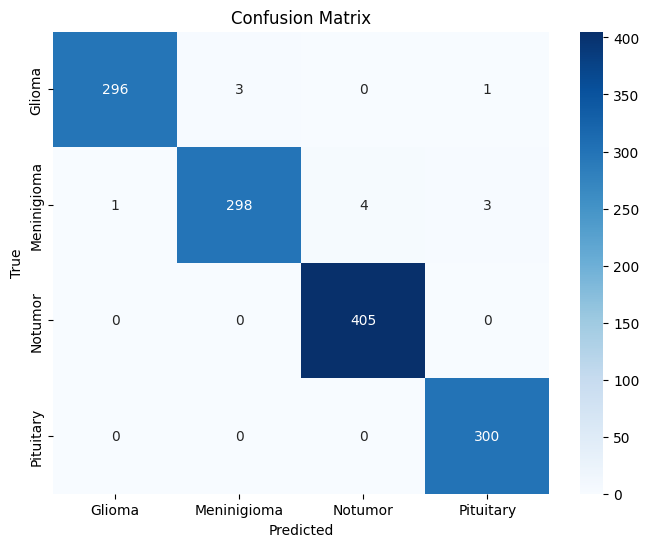

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()